<a href="https://colab.research.google.com/github/elizabethts/DS-Unit-2-Applied-Modeling/blob/master/Caterpillar_Tube_Pricing_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries/Modules

In [2]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.5MB/s 


In [121]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
from glob import glob
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
import warnings
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
xgb.__version__

'0.90'

## Competition 
#### The dataset is comprised of a large number of relational tables that describe the physical properties of tube assemblies. You are challenged to combine the characteristics of each tube assembly with supplier pricing dynamics in order to forecast a quote price for each tube. The quote price is labeled as cost in the data.
#### https://www.kaggle.com/c/caterpillar-tube-pricing 

#### [Evaluation](https://www.kaggle.com/c/caterpillar-tube-pricing/overview/evaluation)

> Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as
>
> $\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log \left(p_{i}+1\right)-\log \left(a_{i}+1\right)\right)^{2}}$
>
> Where:
>
> - $n$ is the number of price quotes in the test set
> - $p_i$ is your predicted price
> - $a_i$ is the actual price
> - $log(x)$ is the natural logarithm

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle


In [22]:
!pip install kaggle

In [21]:
!kaggle competitions download -c caterpillar-tube-pricing

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
!unzip data.zip

Archive:  data.zip
replace competition_data/bill_of_materials.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv 

In [59]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/comp_other.csv (1001, 3)
competition_data/comp_adaptor.csv (25, 20)
competition_data/components.csv (2048, 3)
competition_data/type_end_form.csv (8, 2)
competition_data/tube.csv (21198, 16)
competition_data/comp_elbow.csv (178, 16)
competition_data/type_connection.csv (14, 2)
competition_data/train_set.csv (30213, 8)
competition_data/comp_tee.csv (4, 14)
competition_data/comp_straight.csv (361, 12)
competition_data/comp_float.csv (16, 7)
competition_data/comp_boss.csv (147, 15)
competition_data/comp_hfl.csv (6, 9)
competition_data/comp_nut.csv (65, 11)
competition_data/tube_end_form.csv (27, 2)
competition_data/comp_sleeve.csv (50, 10)
competition_data/test_set.csv (30235, 8)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/comp_threaded.csv (194, 32)
competition_data/specs.csv (21198, 11)
competition_data/type_component.csv (29, 2)


In [0]:
# create function for RMSLE

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
  
# create function for RMSE

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [0]:
# train and test data

train = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

In [62]:
print(train.shape)
train.head()

(30213, 8)


,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [63]:
print(test.shape)
test.head()

(30235, 8)


,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25


In [64]:
# train and test data

trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

# get unique tube_assembly_id
train_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()

# train, val split on id
train_tube_assemblies, val_tube_assemblies = train_test_split(
    train_tube_assemblies, random_state=42
)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

def wrangle(X):
  X = X.copy()
  
  # Engineer date features
  X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
  X['quote_date_year'] = X['quote_date'].dt.year
  X['quote_date_month'] = X['quote_date'].dt.month
  X = X.drop(columns = 'quote_date')
  
  # Drop tube_assembly_id because our goal is to predict unknown assemblies
  #X = X.drop(columns = 'tube_assembly_id')
  
  return X

target = 'cost'
train = wrangle(train)
val = wrangle(val)
test = wrangle(test.drop('id',1))
train.shape, val.shape, test.shape


# X and y
features = train.drop(target, 1).columns.tolist()
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((22628, 8), (22628,), (7585, 8), (7585,), (30235, 8))

In [65]:
features

['tube_assembly_id',
 'supplier',
 'annual_usage',
 'min_order_quantity',
 'bracket_pricing',
 'quantity',
 'quote_date_year',
 'quote_date_month']

In [66]:
# create baseline model by predicting mean cost


y_pred = [y_train.mean()] * len(X_val)

# can also use this
# y_pred = np.full_like(y_val, fill_value=y_train.mean()) 

print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))
print('Validation R^2, Mean Baseline:', r2_score(y_val, y_pred))

# R^2 is basically 0 meaning that the line is not a good fit

Validation RMSLE, Mean Baseline: 0.9418101276064408
Validation R^2, Mean Baseline: -4.701447715138585e-06


Create a linear regression model

In [67]:
# train and test data

trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

# get unique tube_assembly_id
train_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()

# train, val split on id
train_tube_assemblies, val_tube_assemblies = train_test_split(
    train_tube_assemblies, random_state=42
)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

def wrangle(X):
  X = X.copy()
  
  # Engineer date features
  X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
  X['quote_date_year'] = X['quote_date'].dt.year
  X['quote_date_month'] = X['quote_date'].dt.month
  X = X.drop(columns = 'quote_date')
  
  # Drop tube_assembly_id because our goal is to predict unknown assemblies
  #X = X.drop(columns = 'tube_assembly_id')
  
  return X

target = 'cost'
features = ['quantity']

train = wrangle(train)
val = wrangle(val)
test = wrangle(test.drop(columns='id'))
train.shape, val.shape, test.shape


# X and y
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]



model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
r2 = model.score(X_val, y_val)
# print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))
# print('Validation R^2, Mean Baseline:', r2_score(y_val, y_pred))
print('Validation R^2', r2)
print('\n')

y_pred = model.predict(X_val)
print(f'Validation RMSLE, Random Forest with {features}')
print(rmsle(y_val, y_pred),'\n')


y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('Log transformed target:')
print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))
print('Validation RMSE, Mean Baseline:', rmse(y_val_log, y_pred_log))

#score improved



Validation R^2 0.08879518736792147


Validation RMSLE, Random Forest with ['quantity']
0.6908805822519186 

Log transformed target:
Validation RMSLE, Mean Baseline: 0.622925465880199
Validation RMSE, Mean Baseline: 0.622925465880199


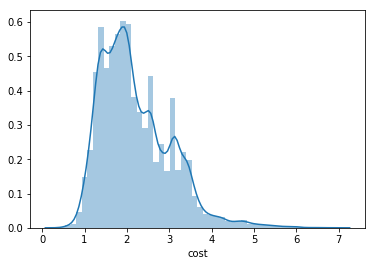

In [68]:
y_train_log = np.log1p(y_train)
sns.distplot(y_train_log)


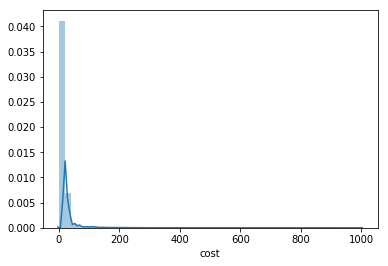

In [69]:
y_train_log_exp = np.expm1(y_train_log)
sns.distplot(y_train_log_exp);

In [70]:
rf = model.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

AttributeError: ignored

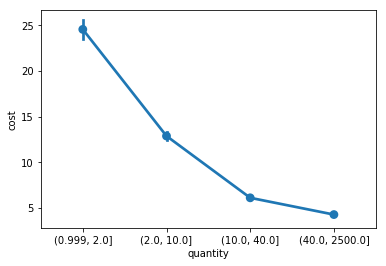

In [71]:
quantity_quartiles = pd.qcut(train_wrangled['quantity'], q=4)
sns.pointplot(x=quantity_quartiles, y=train_wrangled['cost']);

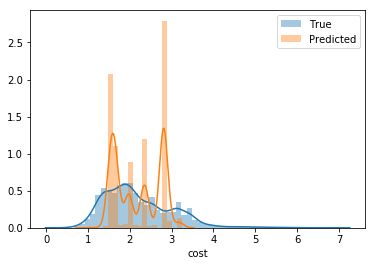

In [72]:
import matplotlib.pyplot as plt
sns.distplot(y_val_log, label='True')
sns.distplot(y_pred_log, label='Predicted')
plt.legend();

In [73]:
# train and test data

trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

# get unique tube_assembly_id
train_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()

# train, val split on id
train_tube_assemblies, val_tube_assemblies = train_test_split(
    train_tube_assemblies, random_state=42
)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

def wrangle(X):
  X = X.copy()
  
  # Engineer date features
  X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
  X['quote_date_year'] = X['quote_date'].dt.year
  X['quote_date_month'] = X['quote_date'].dt.month
  X = X.drop(columns = 'quote_date')
  
  # Drop tube_assembly_id because our goal is to predict unknown assemblies
  X = X.drop(columns = 'tube_assembly_id')
  
  return X


train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test.drop(columns='id'))
print(train.shape, val.shape, test.shape)


# X and y
target = 'cost'
features = train_wrangled.columns.drop(target)
X_train = train_wrangled[features]
y_train = train_wrangled[target]
X_val = val_wrangled[features]
y_val = val_wrangled[target]
X_test = test_wrangled[features]


pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
print(f'Validation RMSE w/ {features.values}',rmse(y_val_log, y_pred_log))


(22628, 8) (7585, 8) (30235, 8)
Validation RMSE w/ ['supplier' 'annual_usage' 'min_order_quantity' 'bracket_pricing'
 'quantity' 'quote_date_year' 'quote_date_month'] 0.3950096664322286


###Do feature engineering with relational database


In [74]:
for path in glob('competition_data/*csv'):
  df = pd.read_csv(path)
  shared_columns = set(df.columns) & set(train.columns)
  if shared_columns:
    print(path,df.shape)
    print(df.columns.tolist(), '\n')

competition_data/tube.csv (21198, 16)
['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other'] 

competition_data/train_set.csv (30213, 8)
['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'cost'] 

competition_data/test_set.csv (30235, 8)
['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity'] 

competition_data/bill_of_materials.csv (21198, 17)
['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8'] 

competition_data/specs.csv (21198, 11)
['tube_assembly_id', 'spec1', 'spec2', 'spec3', 'spec4', 'spec

In [75]:
tube = pd.read_csv('competition_data/tube.csv')
tube.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [76]:
tube.describe()

,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000
mean,23.687764,1.578402,100.312844,3.748137,49.350767,0.044485,0.006746,0.022644
std,25.396277,0.745749,70.542771,2.265405,196.468480,0.260737,0.100015,0.199676
min,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,15.880000,1.650000,86.000000,3.000000,38.100000,0.000000,0.000000,0.000000
75%,25.400000,1.650000,135.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,5.000000,8.000000


In [77]:
tube.describe(exclude = 'number')

,tube_assembly_id,material_id,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x
count,21198,20919,21198,21198,21198,21198,21198,21198
unique,21198,19,2,2,2,2,25,27
top,TA-02509,SP-0029,N,N,N,N,EF-003,EF-003
freq,1,11488,20118,18015,20377,18493,11388,10863


In [78]:
# train and test data

trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

# get unique tube_assembly_id
train_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()

# train, val split on id
train_tube_assemblies, val_tube_assemblies = train_test_split(
    train_tube_assemblies, random_state=42
)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv('competition_data/tube.csv')
    X = X.merge(tube, how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X


train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test.drop(columns='id'))
print(train_wrangled.shape, val_wrangled.shape, test_wrangled.shape)

# X and y
target = 'cost'
features = train_wrangled.columns.drop(target)
X_train = train_wrangled[features]
y_train = train_wrangled[target]
X_val = val_wrangled[features]
y_val = val_wrangled[target]
X_test = test_wrangled[features]
all(X_test.columns == X_train.columns)


pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
print(f'Validation RMSE w/ {features.values}',rmse(y_val_log, y_pred_log))



(22628, 23) (7585, 23) (30235, 22)
Validation RMSE w/ ['supplier' 'annual_usage' 'min_order_quantity' 'bracket_pricing'
 'quantity' 'quote_date_year' 'quote_date_month' 'material_id' 'diameter'
 'wall' 'length' 'num_bends' 'bend_radius' 'end_a_1x' 'end_a_2x'
 'end_x_1x' 'end_x_2x' 'end_a' 'end_x' 'num_boss' 'num_bracket' 'other'] 0.3071425826783341


In [0]:
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)


sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['cost'] = y_pred
submission.to_csv('submission-01.csv', index=False)

In [80]:
submission.head()

,id,cost
0,1,23.372078
1,2,13.786769
2,3,7.868861
3,4,5.840275
4,5,4.675781


In [0]:
# change file name and note

#!kaggle competitions submit -c caterpillar-tube-pricing -f submission-01.csv -m "first submission"

In [0]:
SOURCE = 'competition_data/'
data = {}
for path in glob(SOURCE + '*.csv'):
    df = pd.read_csv(path)
    filename = path.split('/')[-1]
    name = filename.split('.')[0]
    data[name] = df

In [0]:
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv(SOURCE + 'tube.csv')
    X = X.merge(tube, how='left')
    
    # Engineer features from bill_of_materials
    materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')
    
    materials['components_total'] = (materials['quantity_1'].fillna(0) + 
                                     materials['quantity_2'].fillna(0) + 
                                     materials['quantity_3'].fillna(0) + 
                                     materials['quantity_4'].fillna(0) + 
                                     materials['quantity_5'].fillna(0) + 
                                     materials['quantity_6'].fillna(0) + 
                                     materials['quantity_7'].fillna(0) + 
                                     materials['quantity_8'].fillna(0))

    materials['components_distinct'] = (materials['component_id_1'].notnull().astype(int) + 
                                        materials['component_id_2'].notnull().astype(int) + 
                                        materials['component_id_3'].notnull().astype(int) + 
                                        materials['component_id_4'].notnull().astype(int) + 
                                        materials['component_id_5'].notnull().astype(int) + 
                                        materials['component_id_6'].notnull().astype(int) + 
                                        materials['component_id_7'].notnull().astype(int) + 
                                        materials['component_id_8'].notnull().astype(int))
    
    # Merge selected features from bill_of_materials
    # Just use the first component_id, ignore the others for now!
    features = ['tube_assembly_id', 'component_id_1', 'components_total', 'components_distinct']
    X = X.merge(materials[features], how='left')
    
    # Get component_type_id (has lower cardinality than component_id)
    components = pd.read_csv(SOURCE + 'components.csv')
    components = components.rename(columns={'component_id': 'component_id_1'})
    features = ['component_id_1', 'component_type_id']
    X = X.merge(components[features], how='left')
    
    # Count the number of specs for the tube assembly
    specs = pd.read_csv(SOURCE + 'specs.csv')
    specs['specs_total'] = specs.drop(columns=['tube_assembly_id']).count(axis=1)
    features = ['tube_assembly_id', 'specs_total', 'spec1']
    X = X.merge(specs[features], how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X
  
# Read data
trainval = pd.read_csv(SOURCE + 'train_set.csv')
test = pd.read_csv(SOURCE + 'test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [85]:
%%time

# make pipeline
pipe = make_pipeline(
  ce.OrdinalEncoder(),
  RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# fit
pipe.fit(X_train, y_train_log)

# validate
y_pred_log = pipe.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))


#predict
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log) # convert from log-dollars to dollars
    submission = pd.read_csv(SOURCE + '../sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)
    
generate_submission(pipe, X_test, 'submission-02.csv')

Validation Error 0.2958563668935705
CPU times: user 22.2 s, sys: 328 ms, total: 22.6 s
Wall time: 11.7 s


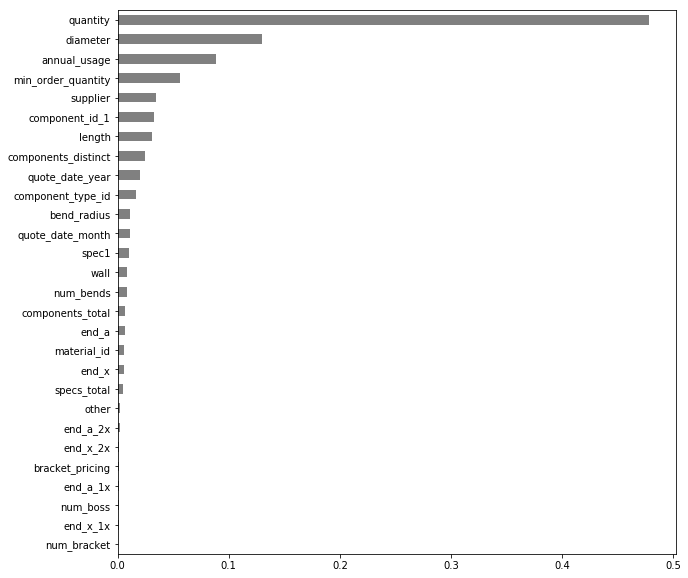

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
rf = pipe.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

In [87]:
%%time

# make pipeline n = 100
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=100, n_jobs=-1)
)
pipe.fit(X_train, y_train_log)
y_pred_log = pipe.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

#score 0.3335

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:51:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.33353003763257383
CPU times: user 3.32 s, sys: 40 ms, total: 3.36 s
Wall time: 2 s


In [88]:
%%time

# make pipeline n = 1000
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=1000, n_jobs=-1)
)
pipe.fit(X_train, y_train_log)
y_pred_log = pipe.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))
 
# score 0.2700

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:51:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.2700581596577784
CPU times: user 29.7 s, sys: 53.8 ms, total: 29.8 s
Wall time: 15.1 s


In [89]:
# encode train, val, test 
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]

# model
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, 
          early_stopping_rounds=10, eval_metric='rmse', 
          eval_set=eval_set)

[05:51:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71924	validation_1-rmse:1.70846
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.56516	validation_1-rmse:1.55498


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[2]	validation_0-rmse:1.42779	validation_1-rmse:1.41846
[3]	validation_0-rmse:1.30338	validation_1-rmse:1.2943
[4]	validation_0-rmse:1.19168	validation_1-rmse:1.18295
[5]	validation_0-rmse:1.09322	validation_1-rmse:1.08553
[6]	validation_0-rmse:1.0052	validation_1-rmse:0.997831
[7]	validation_0-rmse:0.927625	validation_1-rmse:0.922043
[8]	validation_0-rmse:0.859916	validation_1-rmse:0.857021
[9]	validation_0-rmse:0.799929	validation_1-rmse:0.798434
[10]	validation_0-rmse:0.747475	validation_1-rmse:0.747741
[11]	validation_0-rmse:0.700332	validation_1-rmse:0.700594
[12]	validation_0-rmse:0.660555	validation_1-rmse:0.662626
[13]	validation_0-rmse:0.623149	validation_1-rmse:0.625612
[14]	validation_0-rmse:0.592345	validation_1-rmse:0.5964
[15]	validation_0-rmse:0.563783	validation_1-rmse:0.568364
[16]	validation_0-rmse:0.540559	validation_1-rmse:0.546317
[17]	validation_0-rmse:0.519686	validation_1-rmse:0.5262
[18]	validation_0-rmse:0.501662	validation_1-rmse:0.509163
[19]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [90]:
sum(range(1,542))

146611

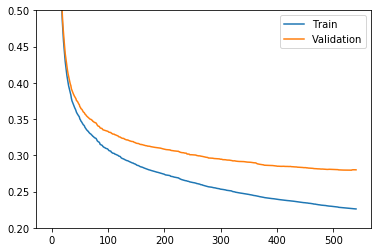

In [91]:
# look at results
results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.ylim((0.2,0.5))
plt.legend();

In [0]:
# validation_1-rmse:0.27946
# Kaggle 0.29454

generate_submission(model, X_test_encoded, 'submission-02.csv')

# change file name and note

#!kaggle competitions submit -c caterpillar-tube-pricing -f submission-02.csv -m "second submission"

In [93]:
df = pd.read_csv('submission-02.csv')
df.head()

,id,cost
0,1,23.884161
1,2,13.974995
2,3,7.856282
3,4,5.379465
4,5,4.180255


### Get a tidy list of the component id's in each tube assembly


In [94]:
materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')

assembly_components = materials.melt(id_vars = 'tube_assembly_id',
                                    value_vars=[f'component_id_{n}' for n in range(1,9)])

assembly_components = (assembly_components
                       .sort_values(by='tube_assembly_id')
                       .dropna()
                       .rename(columns={'value': 'component_id'})) 


assembly_components.head(10)

,tube_assembly_id,variable,component_id
0,TA-00001,component_id_1,C-1622
21198,TA-00001,component_id_2,C-1629
1,TA-00002,component_id_1,C-1312
2,TA-00003,component_id_1,C-1312
3,TA-00004,component_id_1,C-1312
4,TA-00005,component_id_1,C-1624
42400,TA-00005,component_id_3,C-1641
21202,TA-00005,component_id_2,C-1631
5,TA-00006,component_id_1,C-1624
21203,TA-00006,component_id_2,C-1631


###Merge w/ component types

In [95]:
components = pd.read_csv(SOURCE + 'components.csv')
assembly_component_types = assembly_components.merge(components, how='left')
assembly_component_types.head(10)

,tube_assembly_id,variable,component_id,name,component_type_id
0,TA-00001,component_id_1,C-1622,NUT-SWIVEL,CP-025
1,TA-00001,component_id_2,C-1629,SLEEVE-ORFS,CP-024
2,TA-00002,component_id_1,C-1312,NUT-FLARED,CP-028
3,TA-00003,component_id_1,C-1312,NUT-FLARED,CP-028
4,TA-00004,component_id_1,C-1312,NUT-FLARED,CP-028
5,TA-00005,component_id_1,C-1624,NUT-SWIVEL,CP-025
6,TA-00005,component_id_3,C-1641,CONNECTOR-SEAL,CP-014
7,TA-00005,component_id_2,C-1631,SLEEVE-ORFS,CP-024
8,TA-00006,component_id_1,C-1624,NUT-SWIVEL,CP-025
9,TA-00006,component_id_2,C-1631,SLEEVE-ORFS,CP-024


###Make a crosstab of the component types for each assembly (one-hot encoding)

In [96]:
table = pd.crosstab(assembly_component_types['tube_assembly_id'],
                    assembly_component_types['component_type_id'])

table = table.reset_index()
table.columns.name = ''
print(table.shape)
table.head()

(19149, 30)


,tube_assembly_id,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,CP-008,CP-009,CP-010,CP-011,CP-012,CP-014,CP-015,CP-016,CP-017,CP-018,CP-019,CP-020,CP-021,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER
0,TA-00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [97]:
def search_column(name):
    for path in glob(SOURCE + '*.csv'):
        df = pd.read_csv(path)
        if name in df.columns:
            print(path, df.shape)
            print(df.columns.tolist(), '\n')

search_column('weight')

competition_data/comp_other.csv (1001, 3)
['component_id', 'part_name', 'weight'] 

competition_data/comp_adaptor.csv (25, 20)
['component_id', 'component_type_id', 'adaptor_angle', 'overall_length', 'end_form_id_1', 'connection_type_id_1', 'length_1', 'thread_size_1', 'thread_pitch_1', 'nominal_size_1', 'end_form_id_2', 'connection_type_id_2', 'length_2', 'thread_size_2', 'thread_pitch_2', 'nominal_size_2', 'hex_size', 'unique_feature', 'orientation', 'weight'] 

competition_data/comp_elbow.csv (178, 16)
['component_id', 'component_type_id', 'bolt_pattern_long', 'bolt_pattern_wide', 'extension_length', 'overall_length', 'thickness', 'drop_length', 'elbow_angle', 'mj_class_code', 'mj_plug_class_code', 'plug_diameter', 'groove', 'unique_feature', 'orientation', 'weight'] 

competition_data/comp_tee.csv (4, 14)
['component_id', 'component_type_id', 'bolt_pattern_long', 'bolt_pattern_wide', 'extension_length', 'overall_length', 'thickness', 'drop_length', 'mj_class_code', 'mj_plug_class_c

In [98]:
comp_threaded = pd.read_csv(SOURCE + 'comp_threaded.csv')
comp_threaded['orientation'].value_counts()

No     121
Yes     73
Name: orientation, dtype: int64

In [99]:
comp_threaded['unique_feature'].value_counts()

No     161
Yes     33
Name: unique_feature, dtype: int64

In [100]:
comp = pd.concat((pd.read_csv(path) for path in glob(SOURCE + 'comp_*.csv')))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
comp = pd.concat((pd.read_csv(path) for path in glob(SOURCE + 'comp_*.csv')), sort=False)
columns = ['component_id', 'component_type_id', 'orientation', 'unique_feature', 'weight']
comp = comp[columns]
comp['orientation'] = (comp['orientation']=='Yes').astype(int)
comp['unique_feature'] = (comp['unique_feature']=='Yes').astype(int)
comp['weight'] = comp['weight'].fillna(comp['weight'].median())

In [104]:
comp.head()

,component_id,component_type_id,orientation,unique_feature,weight
0,C-1385,NaN,0,0,0.014
1,C-1386,NaN,0,0,0.005
2,C-1369,NaN,0,0,0.003
3,C-0422,NaN,0,0,0.003
4,C-1817,NaN,0,0,0.014


### 2d. Engineer features, aggregated for all components in a tube assembly
- Components total
- Components distinct
- Orientation 
- Unique Feature
- Weight

In [105]:
materials['components_total'] = sum(materials[f'quantity_{n}'].fillna(0)  for n in range(1,9))
materials['components_distinct'] = sum(materials[f'component_id_{n}'].notnull().astype(int) for n in range(1,9))
materials['orientation'] = 0
materials['unique_feature'] = 0
materials['weight'] = 0

for n in range(1,9):
    materials = materials.merge(comp, left_on=f'component_id_{n}', right_on='component_id', 
                                how='left', suffixes=('', f'_{n}'))

for col in materials:
    if 'orientation' in col or 'unique_feature' in col or 'weight' in col:
        materials[col] = materials[col].fillna(0)
        
materials['orientation'] = sum(materials[f'orientation_{n}'] for n in range(1,9))
materials['unique_feature'] = sum(materials[f'unique_feature_{n}'] for n in range(1,9))
materials['weight'] = sum(materials[f'weight_{n}'] for n in range(1,9))

materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,components_total,components_distinct,orientation,unique_feature,weight,component_id,component_type_id,orientation_1,unique_feature_1,weight_1,component_id_2,component_type_id_2,orientation_2,unique_feature_2,weight_2,component_id_3,component_type_id_3,orientation_3,unique_feature_3,weight_3,component_id_4,component_type_id_4,orientation_4,unique_feature_4,weight_4,component_id_5,component_type_id_5,orientation_5,unique_feature_5,weight_5,component_id_6,component_type_id_6,orientation_6,unique_feature_6,weight_6,component_id_7,component_type_id_7,orientation_7,unique_feature_7,weight_7,component_id_8,component_type_id_8,orientation_8,unique_feature_8,weight_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2,0.0,1.0,0.048,C-1622,CP-025,0.0,0.0,0.036,C-1629,CP-024,0.0,1.0,0.012,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,C-1312,CP-028,0.0,0.0,0.009,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,C-1312,CP-028,0.0,0.0,0.009,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,C-1312,CP-028,0.0,0.0,0.009,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,0.0,1.0,0.210,C-1624,CP-025,0.0,0.0,0.035,C-1631,CP-024,0.0,1.0,0.026,C-1641,CP-014,0.0,0.0,0.149,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [106]:
features = ['tube_assembly_id', 'orientation', 'unique_feature', 'weight', 
            'components_total', 'components_distinct', 'component_id_1']
materials = materials[features]
print(materials.shape)
materials.head()

(21198, 7)


,tube_assembly_id,orientation,unique_feature,weight,components_total,components_distinct,component_id_1
0,TA-00001,0.0,1.0,0.048,4.0,2,C-1622
1,TA-00002,0.0,0.0,0.009,2.0,1,C-1312
2,TA-00003,0.0,0.0,0.009,2.0,1,C-1312
3,TA-00004,0.0,0.0,0.009,2.0,1,C-1312
4,TA-00005,0.0,1.0,0.210,3.0,3,C-1624


In [0]:
# Read data
trainval = pd.read_csv(SOURCE + 'train_set.csv')
test = pd.read_csv(SOURCE + 'test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge data
    X = (X.merge(table, how='left')
         .merge(materials, how='left')
         .merge(tube, how='left')
         .fillna(0))
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    return X

train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [0]:
target = 'cost'
X_train = train_wrangled.drop(columns=target)
X_val = val_wrangled.drop(columns=target)
X_test = test_wrangled.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [113]:
warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)
eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]
model = XGBRegressor(n_estimators=2000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[05:59:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71966	validation_1-rmse:1.70913
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.56462	validation_1-rmse:1.55419
[2]	validation_0-rmse:1.42742	validation_1-rmse:1.41758
[3]	validation_0-rmse:1.30251	validation_1-rmse:1.29309
[4]	validation_0-rmse:1.19029	validation_1-rmse:1.18093
[5]	validation_0-rmse:1.09307	validation_1-rmse:1.08376
[6]	validation_0-rmse:1.00384	validation_1-rmse:0.994622
[7]	validation_0-rmse:0.925172	validation_1-rmse:0.916505
[8]	validation_0-rmse:0.856916	validation_1-rmse:0.849009
[9]	validation_0-rmse:0.794484	validation_1-rmse:0.786692
[10]	validation_0-rmse:0.741354	validation_1-rmse:0.734697
[11]	validation_0-rmse:0.693082	validation_1-rmse:0.686452
[12]	validation_0-rmse:0.6526

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [115]:
# validation_1-rmse: 0.25048
# Kaggle 0.26083

#change filename

generate_submission(model, X_test_encoded, 'submission-03.csv')

# change file name and note
#!kaggle competitions submit -c caterpillar-tube-pricing -f submission-03.csv -m "third submission"

df = pd.read_csv('submission-03.csv')
df.head()

100% 450k/450k [00:00<00:00, 1.27MB/s]
Successfully submitted to Caterpillar Tube Pricing

,id,cost
0,1,23.512226
1,2,13.459983
2,3,7.825382
3,4,5.455750
4,5,4.427710


In [117]:
%%time


pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 5
groups = train['tube_assembly_id']
scores = cross_val_score(pipeline, X_train, y_train_log, cv=k, 
                         scoring='neg_mean_squared_error', groups=groups)
print(f'RMSLE for {k} folds:', np.sqrt(-scores))

RMSLE for 5 folds: [0.29528281 0.27577947 0.31784043 0.37840862 0.28883433]
CPU times: user 4.85 s, sys: 828 ms, total: 5.68 s
Wall time: 59.6 s


In [118]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestregressor'])

Model Hyperparameters:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


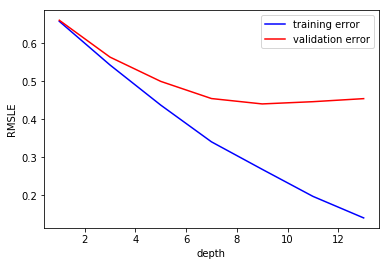

In [120]:
pipeline = make_pipeline(ce.OrdinalEncoder(), DecisionTreeRegressor())

depth = range(1, 15, 2)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train_log,
    param_name='decisiontreeregressor__max_depth', 
    param_range=depth, scoring='neg_mean_squared_error', 
    cv=2, groups=groups)

train_rmsle = np.sqrt(-train_scores)
val_rmsle = np.sqrt(-val_scores)
plt.plot(depth, np.mean(train_rmsle, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(val_rmsle, axis=1), color='red', label='validation error')
plt.xlabel('depth')
plt.ylabel('RMSLE')
plt.legend();

In [122]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_features': uniform(0, 1), 
    'randomforestregressor__max_features': [0.3, 0.5, 0.7]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=20, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train_log, groups=groups);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   41.1s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 

In [124]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 827}
Cross-validation RMSLE 0.3135871034133957


In [123]:
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(random_state=42)
)

param_distributions = {
    'xgbregressor__n_estimators': randint(500, 1000), 
    'xgbregressor__max_depth': randint(3, 7)
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train_log, groups=groups);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.9min finished


[06:49:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [125]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 827}
Cross-validation RMSLE 0.3135871034133957


In [0]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

In [102]:
# validation_1-rmse: 
# Kaggle 

#change filename

generate_submission(model, X_test_encoded, 'submission-02.csv')

# change file name and note
#!kaggle competitions submit -c caterpillar-tube-pricing -f submission-02.csv -m "second submission"

df = pd.read_csv('submission-02.csv')
df.head()

,id,cost
0,1,23.884161
1,2,13.974995
2,3,7.856282
3,4,5.379465
4,5,4.180255
